# Customer Attrition Analysis

## Problem statement

- Customer attrition/churn defined as loss of customers.
- Often used as KPI to measure business performance.
- In many cases retaining customers is cheaper than bringing new customers.
- Employ strategies to retain customers.

## Goal
- Using the data at hand:
- What are the characteristics of customers who churn?
- Can we predict customers who will churn?
- If we can, what can steps can the business take to retain them?

In [1]:
# Importing all the needed modules

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importing scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score 
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("deep")
sns.set_style("darkgrid")
%matplotlib inline

### Data available

In [3]:
df = pd.read_csv('Telecom_Customer_Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [5]:
df.columns.tolist()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [6]:
telco_data = df.copy()

col_names = df.columns.tolist()
non_categorical_columns = ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

cat_col_names =[]

for col in col_names:
    if col not in non_categorical_columns:
        telco_data[col] = telco_data[col].astype('category')
        cat_col_names.append(col)
        
target_variable = 'Churn'

cat_col_names.remove('Churn')
col_names.remove('Churn')

telco_data['TotalCharges'] = telco_data['TotalCharges'].replace(" ", np.nan).astype(float)


11

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
telco_data['TotalCharges'] = imputer.fit_transform(telco_data[['TotalCharges']])

## Exploratory analysis

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

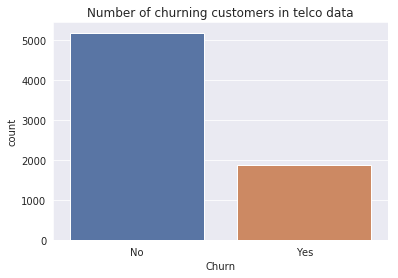

In [10]:
sns.countplot(x='Churn',data=telco_data)
plt.title('Number of churning customers in telco data')

telco_data['Churn'].value_counts(normalize=True) * 100

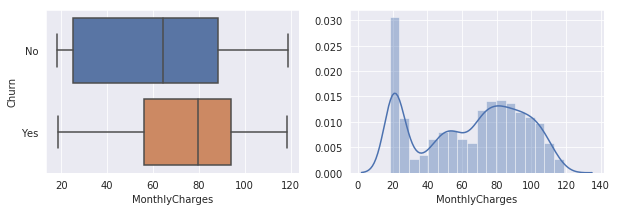

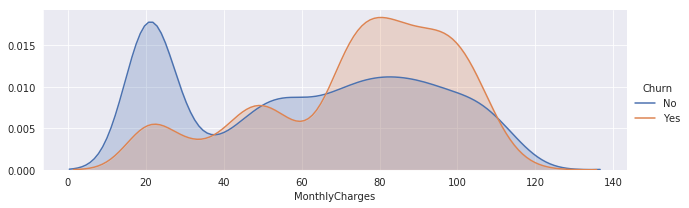

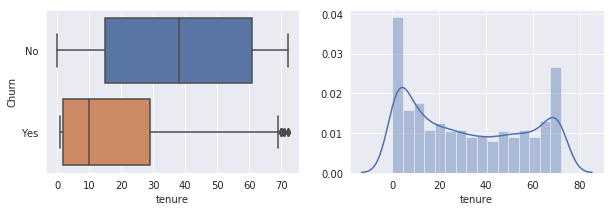

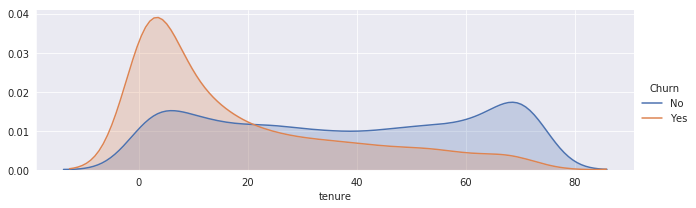

In [12]:
numerical_columns = ['MonthlyCharges', 'tenure']
for i, col in enumerate(numerical_columns):       
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10, 3))    
    sns.boxplot(x=col, y='Churn', data=telco_data, ax=ax1)    
    sns.distplot(telco_data[col], ax=ax2)    
    sns.FacetGrid(telco_data, hue='Churn', height = 3, aspect =3).map(sns.kdeplot, col, shade=True).add_legend() 

### Insights

- Obvious: Clients with higher charges churn more.
- Median price paid by churning customer is approx 15 \$ higher then stayinig customer.
- Most of the clients who churn are recent clients.
- Median Tenure of churning client is about 10 months.

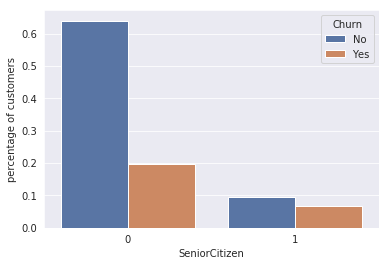

In [46]:
g = telco_data.groupby('SeniorCitizen')["Churn"].value_counts().to_frame()
g = g.rename({"Churn": 'percentage of customers'}, axis=1).reset_index()
g['percentage of customers'] = g['percentage of customers']/len(telco_data)
sns.barplot(x='SeniorCitizen', y= 'percentage of customers', hue='Churn', data=g)

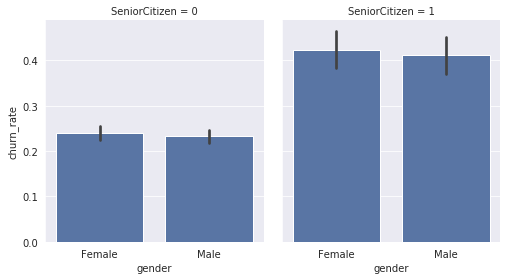

In [45]:
telco_data['churn_rate'] = telco_data['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(telco_data, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", order= ['Female', 'Male'])


## Insights

- Senior citizens constitute approx 16% of customers
- Churn rate of senior citizens 42% vs 23% non senior citizens. 

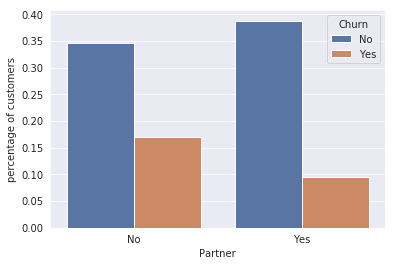

In [49]:
gp_partner = telco_data.groupby('Partner')["Churn"].value_counts()/len(telco_data)
gp_partner = gp_partner.to_frame().rename({"Churn": 'percentage of customers'}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= 'percentage of customers', hue='Churn', data=gp_partner)

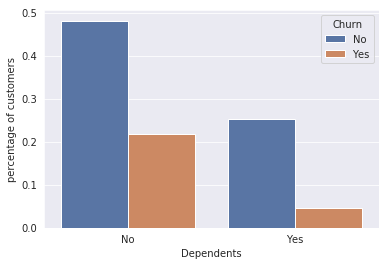

In [50]:
gp_dep = telco_data.groupby('Dependents')["Churn"].value_counts()/len(telco_data)
gp_dep = gp_dep.to_frame().rename({"Churn": 'percentage of customers'}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= 'percentage of customers', hue='Churn', data=gp_dep, )

## Insights

- Customers with partners churn less than customers without partners.
- Customers with dependents churn less than customers without dependents.

In [13]:
X = telco_data[col_names].drop(['customerID', 'TotalCharges'], axis=1)

y = telco_data['Churn']

scaler = StandardScaler()
scalar_X = pd.DataFrame(scaler.fit_transform(X[numerical_columns]), columns=numerical_columns)

dummy_X = pd.get_dummies(data = X, columns=cat_col_names, drop_first=True)
    

X = pd.merge(scalar_X, dummy_X.drop(numerical_columns, axis=1), left_index=True, right_index=True)
y = y.cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y )
predictors = X_train.columns

smote = SMOTE()
smote_X, smote_y = smote.fit_sample(X_train, y_train)
X_train = pd.DataFrame(data=smote_X, columns=predictors)
y_train = pd.DataFrame(data=smote_y, columns=[target_variable])

y_train['Churn'].value_counts()

1    3622
0    3622
Name: Churn, dtype: int64

# Predicting Churn

## Building some classification models

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

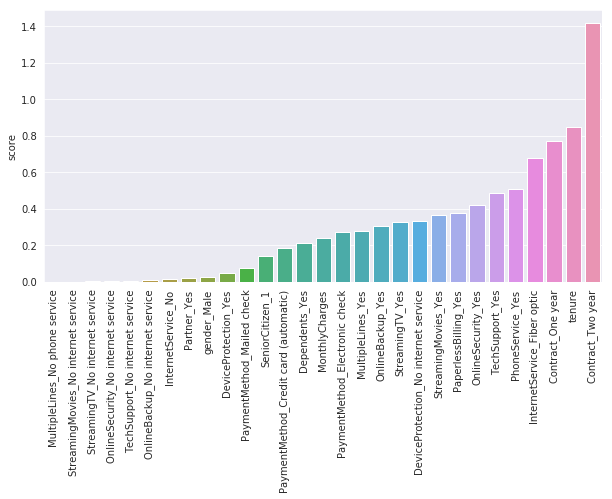

In [16]:
logit = LogisticRegression(penalty='l1')
coef = logit.fit(X_train, y_train).coef_[0]
dictionary = {name:round(c, 4) for name, c in zip(predictors.tolist(), coef.tolist()) }
score_frame = pd.DataFrame.from_dict(dictionary, orient='index', columns=['score'])
score_frame['score'] = score_frame['score'].map(np.abs)
score_frame = score_frame.sort_values(by='score')
fig = plt.figure(figsize=(10,5))
sns.barplot(x = score_frame.index, y='score', data=score_frame)
plt.xticks(rotation=90)


In [17]:
important_features = score_frame.iloc[-15:,:].index.tolist()

X_train = X_train[important_features]
X_test = X_test[important_features]

In [18]:
rf_param_grid = {
    "clf__max_features": range(2, 7),
    "clf__min_samples_split": range(4, 10),
    "clf__min_samples_leaf": range(1, 6),
    
}

# Creating imbalanced learn pipeline for proper handling of SMOTE data in GridSearch

rf_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(
    n_estimators=20, criterion="entropy", random_state=42))
    ])

# Grid search over parameter space
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.3min finished


In [19]:
knn_param_grid = {'clf__n_neighbors':[4, 8, 16], 'clf__weights': ['uniform', 'distance']}

knn_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', KNeighborsClassifier())
    ])

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, scoring='f1', n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.4s finished


In [20]:
logit_params = {'clf__penalty': ['l1', 'l2'], 'clf__C':0.001 * 10**(np.arange(0, 1.01, 0.01) * 3)}

logit_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

logit_grid = GridSearchCV(logit_pipeline, logit_params, n_jobs=-1, verbose=1)
logit_grid.fit(X_train, y_train)
logit_best = logit_grid.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 202 candidates, totalling 606 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:   16.3s finished


In [21]:
svc_params = {'clf__kernel' : ['rbf'], 'clf__gamma' : [0.01, 0.1, 1], 'clf__C' : [10, 50 ,100, 200]}

svc_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', SVC(probability=True))
    ])

svc_grid = GridSearchCV(svc_pipeline, svc_params, scoring='f1', n_jobs=-1, verbose=True)
svc_grid.fit(X_train, y_train)
svc_best = svc_grid.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.1min finished


## Model evaluation

In [22]:
metrics = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score', 'roc_aur', 'avg_precision']

models_performance = pd.DataFrame(columns=metrics)
conf_matrix = dict()
roc_auc = dict()
precision_recall = dict()

In [23]:
def performance_measure(name, classifier, grid):
    print('Best score in grid:', grid.best_score_)
    print('best parameters in grid\n:', grid.best_params_)
    
    predictions = classifier.predict(X_test)
    probabilities = classifier.predict_proba(X_test)[:,-1]
    models_performance.loc[len(models_performance)] = [
        name,
        accuracy_score(y_test, predictions),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
        f1_score(y_test, predictions),
        roc_auc_score(y_test, predictions),
        average_precision_score(y_test, predictions)
    ]
    
    conf_matrix[name] = confusion_matrix(y_test, predictions)
    fpr, tpr, thresh = roc_curve(y_test, probabilities)    
    roc_auc[name] = (fpr, tpr, thresh, predictions, probabilities)
    p, r, threshold = precision_recall_curve(y_test, probabilities)
    precision_recall[name] = (p, r, threshold, predictions, probabilities) 

In [24]:
performance_measure('SVC', svc_best, svc_grid)
performance_measure('Random Forest', rf_best, rf_grid)
performance_measure('KNN', knn_best, knn_grid)
performance_measure('Logistic Reg', logit_best, logit_grid)

Best score in grid: 0.8381383185627462
best parameters in grid
: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Best score in grid: 0.8231623747887409
best parameters in grid
: {'clf__max_features': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 6}
Best score in grid: 0.8165212885845584
best parameters in grid
: {'clf__n_neighbors': 8, 'clf__weights': 'distance'}
Best score in grid: 0.7720872446162341
best parameters in grid
: {'clf__C': 0.09549925860214359, 'clf__penalty': 'l1'}


In [25]:
models_performance

classifier  accuracy  precision    recall  f1-score   roc_aur  \
0            SVC  0.753904   0.528996  0.666667  0.589905  0.726052   
1  Random Forest  0.783247   0.586265  0.623886  0.604491  0.732368   
2            KNN  0.746332   0.517832  0.647059  0.575277  0.714638   
3   Logistic Reg  0.757690   0.529697  0.778966  0.630592  0.764483   

   avg_precision  
0       0.441164  
1       0.465620  
2       0.428773  
3       0.471300

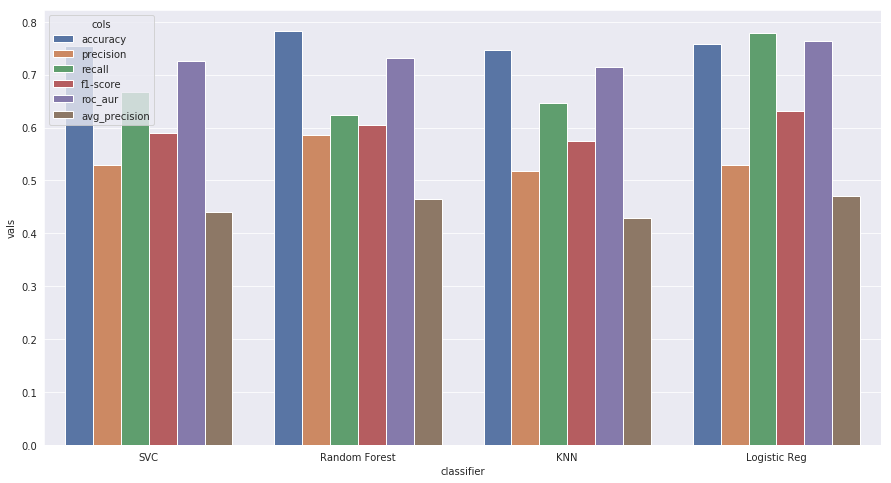

In [26]:
fig = plt.figure(figsize=(15, 8))
temp = models_performance.melt('classifier', var_name='cols', value_name='vals')
sns.barplot(data=temp,x='classifier', y='vals', hue='cols')

In [27]:
fig = plt.figure(figsize=(12, 10))
for i, (classifier, matrix) in enumerate(conf_matrix.items()):
        plt.subplot(3, 3, i+1)
        class_names = ['Not churn', 'Churn']
        sns.heatmap(matrix, 
                    annot=True,
                    xticklabels=["not churn", "churn"],
                    yticklabels=["not churn", "churn"],
                    fmt='d',
                    cmap='viridis'
                   )
        plt.title(classifier)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
plt.tight_layout()        

## Business context recommendation 

We have trained some classifiers and evaluated their performance. How is this information useful in a business context. How can we use what we have learnt to retain customers and remain profitable as a business. 

Based on the precision and recall values of the model for different values of thresholds we can see that changing the threshold can lead to different values in these metrics. In a business setting if somehow we can set a threshold value so that we can maximise our profit/minimise our losses, based on certain business assumptions or requirements then we can tailor our model according to our needs.

I will show this with a simple example scenario:
1. Let us assume that if a customer churns we lose a value of 1.
2. If a customer takes a reward we offer and stays with us we lose 0.1.
3. If a customer stays and does not take reward we lose 0.

Also I will base my analysis on two assumptions:
1. `50%` customers take the reward and stay.
2. All the customers who were not going to churn will take the reward.

I will now try to show how the loss changes with different values of threshold.

In [29]:
name = 'Logistic Reg'
threshold_scv = precision_recall[name][2]
y_prob = precision_recall[name][4]
y_pred = precision_recall[name][3]

accuracy = np.zeros(threshold_scv.shape)
precision = np.zeros(threshold_scv.shape)
recall = np.zeros(threshold_scv.shape)
true_positives = np.zeros(threshold_scv.shape)
false_positives = np.zeros(threshold_scv.shape)
false_negatives = np.zeros(threshold_scv.shape)

for i in range(0,threshold_scv.shape[0]):    
    accuracy[i] = accuracy_score(y_test, y_prob >= threshold_scv[i])
    precision[i] = precision_score(y_test, y_prob >= threshold_scv[i])
    recall[i] =  recall_score(y_test, y_prob >= threshold_scv[i])
    confusion_ = confusion_matrix(y_test, y_prob >= threshold_scv[i])
    true_positives[i] = confusion_[1][1]
    false_positives[i] = confusion_[0][1]
    false_negatives[i] = confusion_[1][0]

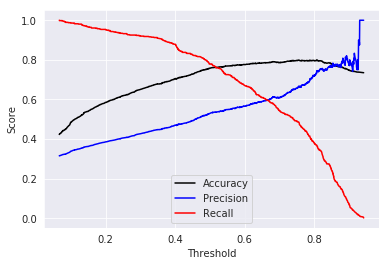

In [30]:
fig = plt.figure()
plt.plot(threshold_scv, accuracy, color='k', label='Accuracy')
plt.plot(threshold_scv, precision, color='b', label='Precision')
plt.plot(threshold_scv, recall, color='r', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center");

In [31]:
# probability that a customer who would churn accepts reward = 50%
prob_reward_accept = 0.5
loss = true_positives * prob_reward_accept * (-0.1) + true_positives * (1 - prob_reward_accept) * (-1) + false_negatives * (-1) + false_positives * (-0.1)

optim_threshold = threshold_scv[loss == max(loss)][0]

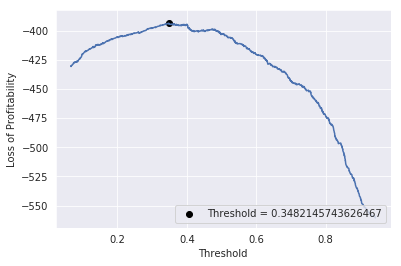

In [32]:
fig = plt.figure()
plt.plot(threshold_scv, loss)
plt.scatter([optim_threshold], [max(loss)], color='black', label=f'Threshold = {optim_threshold}')
plt.xlabel('Threshold')
plt.ylabel('Loss of Profitability')
plt.legend(loc="lower right")

In [34]:
y_preds_new = y_prob > optim_threshold
c_matrix_optim = confusion_matrix(y_test, y_preds_new)

fig = plt.figure()
sns.heatmap(c_matrix_optim, annot=True, fmt='d', xticklabels=['churn', 'not churn'], yticklabels=['churn', 'not churn'])